# Image Classification


## Preprocessing

Downloading the datasets

In [ ]:
!pip install -q kaggle
!pip install hub
!pip install tensorflow
!pip install torchvision
from google.colab import files
from IPython.display import clear_output

clear_output()
files.upload()

!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d trolukovich/food5k-image-dataset
!unzip /content/food5k-image-dataset.zip -d food_5k

clear_output()

Load data into numpy arrays

In [ ]:
import os
import cv2
import numpy as np

def make_nparray(folder_path, dataset_type):
    data = []
    labels = []
    base_path = os.path.join(folder_path, dataset_type)
    for category in os.listdir(base_path):
        category_path = os.path.join(base_path, category)
        for pic in os.listdir(category_path):
            img = cv2.imread(os.path.join(category_path, pic))
            img = cv2.resize(img, (128, 128))
            data.append(img)
            labels.append(category)
    return np.array(data), np.array(labels)

## First Model Training: Is the image of food?

Using a CNN for quick, accurate results

The high dropout rate was to maximize accuracy on images that the model wasn't fit to. Compared to a dropout rate of 0.5, the current one improved accuracy by about 5 percent.

In [ ]:
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalMaxPool2D, Embedding, Dense, Dropout, Flatten

base_path = '/content/food_5k'

train_images, train_labels = make_nparray(base_path, 'training')
train_images = train_images/255.0

test_images, test_labels = make_nparray(base_path, 'evaluation')
test_images = test_images/255.0

validation_images, validation_labels = make_nparray(base_path, 'validation')
validation_images = validation_images/255.0

if len(train_labels.shape) == 1:
  label_encoder = LabelEncoder()
  train_labels = to_categorical(label_encoder.fit_transform(train_labels))
  validation_labels = to_categorical(label_encoder.transform(validation_labels))
  test_labels = to_categorical(label_encoder.transform(test_labels))

model1 = Sequential()
model1.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3)))
model1.add(MaxPooling2D(pool_size=(2,2)))
model1.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3)))
model1.add(MaxPooling2D(pool_size=(2,2)))
model1.add(Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=(128, 128, 3)))
model1.add(MaxPooling2D(pool_size=(2,2)))
model1.add(Conv2D(filters=64, kernel_size=(4, 4), activation='relu', input_shape=(128, 128, 3)))
model1.add(MaxPooling2D(pool_size=(2,2)))
model1.add(Flatten())
model1.add(Dropout(0.75))
model1.add(Dense(256, activation='relu'))
model1.add(Dense(train_labels.shape[1], activation='sigmoid'))

model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model1.fit(train_images, train_labels, epochs=10, validation_data=(validation_images, validation_labels))

Epoch 1/10
94/94 [==============================] - 3s 18ms/step - loss: 0.5206 - accuracy: 0.7490 - val_loss: 0.4332 - val_accuracy: 0.8030
Epoch 2/10
94/94 [==============================] - 1s 11ms/step - loss: 0.4562 - accuracy: 0.7933 - val_loss: 0.3630 - val_accuracy: 0.8470
Epoch 3/10
94/94 [==============================] - 1s 10ms/step - loss: 0.3802 - accuracy: 0.8377 - val_loss: 0.3387 - val_accuracy: 0.8750
Epoch 4/10
94/94 [==============================] - 1s 10ms/step - loss: 0.3457 - accuracy: 0.8513 - val_loss: 0.4375 - val_accuracy: 0.8040
Epoch 5/10
94/94 [==============================] - 1s 10ms/step - loss: 0.3565 - accuracy: 0.8490 - val_loss: 0.2804 - val_accuracy: 0.8960
Epoch 6/10
94/94 [==============================] - 1s 10ms/step - loss: 0.3147 - accuracy: 0.8693 - val_loss: 0.2869 - val_accuracy: 0.8780
Epoch 7/10
94/94 [==============================] - 1s 10ms/step - loss: 0.3065 - accuracy: 0.8810 - val_loss: 0.2842 - val_accuracy: 0.8780
Epoch 8/10
94

### Results

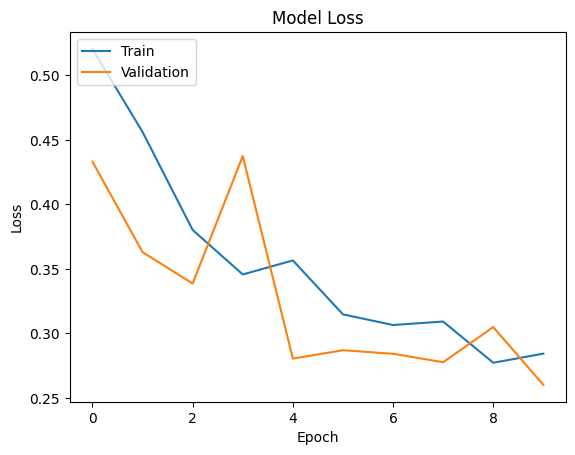

32/32 [==============================] - 0s 5ms/step - loss: 0.3171 - accuracy: 0.8680
Test Accuracy: 0.8679999709129333


In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

loss, accuracy = model1.evaluate(test_images, test_labels)
print(f"Test Accuracy: {accuracy}")

## Downloading

Save the models

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

model1.save('isFood')
model2.save('foodCategory')
model3.save('typeOfFood')

!cp -r /content/isFood /content/drive/MyDrive/models
!cp -r /content/foodCategory /content/drive/MyDrive/models
!cp -r /content/typeOfFood /content/drive/MyDrive/models

Convert the models to tensorflow.js compatible files

In [ ]:
import keras
!pip install tensorflowjs
import tensorflowjs as tfjs
from pathlib import Path
from google.olab import drive

''' *********************************************************************************************

To fix the error with jax import, go into jax_conversion.py then delete the PolyShape declaration
and change the poly_shape import to from jax.experimental.jax2tf import PolyShape
AND
delete the line that says PolyShape = shape_poly

**********************************************************************************************'''

# change this to the model you are saving
model1.save('/content/typeOfFood')

# first one is path to the .pb file, second one is the model path
!tensorflowjs_converter --input_format keras /content/isFood/variables/saved_model.pb /content/isFoodModel

def importModel():
    model = keras.models.load_model('/content/typeOfFood') # where to load the model from
    tfjs.converters.save_keras_model(model, "typeOfFood") # where to save the model to
importModel()
clear_output()

drive.mount('/content/drive')
# change the first path name to model you are saving
!cp -r '/content/typeOfFood' '/content/drive/My Drive/models'

2023-12-27 01:25:25.608879: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-27 01:25:25.608930: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-27 01:25:25.610208: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-27 01:25:26.562567: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Traceback (most recent call last):
  File "/usr/local/bin/tensorflowjs_converter", line 8, in <module>
    sys.exit(pip_main())
  File "/usr/local/lib/python3.10/dist-packages/tensorflowjs/converters/converter.py", line 958, in pip_main
    

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
